In [1]:
import urllib
import os
import sqlite3
import pandas as pd
import time
import numpy as np
from datetime import datetime


In [2]:
FILES_URL = 'https://datasette.planning.data.gov.uk/'

def download_dataset(dataset, output_dir_path, overwrite=False):
    dataset_file_name = f'{dataset}.db'
    
    if not os.path.exists(output_dir_path):
        os.makedirs(output_dir_path)
    
    output_file_path = os.path.join(output_dir_path, dataset_file_name)

    if overwrite is False and os.path.exists(output_file_path):
        return
    
    final_url = os.path.join(FILES_URL, dataset_file_name)
    print(f'downloading data from {final_url}')
    print(f'to: {output_file_path}')
    urllib.request.urlretrieve(final_url, os.path.join(output_dir_path, dataset_file_name))
    print('download complete')

In [3]:
def query_sqlite(db_path, query_string):

    with sqlite3.connect(db_path) as con:
            
        cursor = con.execute(query_string)
        cols = [column[0] for column in cursor.description]
        results_df = pd.DataFrame.from_records(data=cursor.fetchall(), columns=cols)

    return results_df

In [4]:

def datasette_query(db, sql_string):
    params = urllib.parse.urlencode({
        "sql": sql_string,
        "_size": "max"
        })
    url = f"https://datasette.planning.data.gov.uk/{db}.csv?{params}"
    df = pd.read_csv(url)
    return df

def get_issue_lookup():
    
    q = """
    select issue_type, severity, responsibility
    from issue_type
"""
    return datasette_query("digital-land", q)

In [5]:
data_dir = "../../data/db_downloads/"
os.makedirs(data_dir, exist_ok=True)

## Get data

In [6]:
download_dataset("performance", data_dir, overwrite=True)
# download_dataset("article-4-direction-area", data_dir, overwrite=True)
# download_dataset("tree-preservation-zone", data_dir, overwrite=True)

downloading data from https://datasette.planning.data.gov.uk/performance.db
to: ../../data/db_downloads/performance.db
download complete


In [38]:
lookup_issue_qual = pd.read_csv("data/issue_type_quality.csv")

## Analysis

In [24]:
q = f"""
    SELECT 
        rhe.organisation, rhe.name, rhe.collection, rhe.pipeline, rhe.endpoint, rhe.resource, rhe.latest_status, rhe.endpoint_entry_date, rhe.resource_start_date, 
        CAST(JULIANDAY('now') - JULIANDAY(rhe.resource_start_date) AS int) as resource_age_days,
        its.issue_type, its.count_issues, its.severity, its.responsibility
    FROM reporting_historic_endpoints rhe
    LEFT JOIN endpoint_dataset_issue_type_summary its on rhe.resource = its.resource
    WHERE 1=1
        AND rhe.endpoint_end_date = ""
        AND rhe.resource_end_date = ""
        AND rhe.latest_status = 200
"""

ep_res_issues = query_sqlite(os.path.join(data_dir, "performance.db"), q)

print(len(ep_res_issues))
ep_res_issues

2781


,organisation,name,collection,pipeline,endpoint,resource,latest_status,endpoint_entry_date,resource_start_date,resource_age_days,issue_type,count_issues,severity,responsibility
0,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,brownfield-land,brownfield-land,a16e45dbefe2d67a6d27c086768b6c3610d4e057bb1962...,f1e218c96f99e378fdbaed9a426c6b44d0e7d3b5fec63e...,200,2019-12-01,2019-12-01,1782,patch,1.0,info,internal
1,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,brownfield-land,brownfield-land,a16e45dbefe2d67a6d27c086768b6c3610d4e057bb1962...,f1e218c96f99e378fdbaed9a426c6b44d0e7d3b5fec63e...,200,2019-12-01,2019-12-01,1782,default-field,41.0,info,internal
2,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",area-of-outstanding-natural-beauty,area-of-outstanding-natural-beauty,34167c688ca765477c47e63592ff9149bb46710a0850f6...,d4f9a4c7d1bda9026c2079812c5f2fc9e6de231b111b7e...,200,2022-09-10,2024-10-03,14,None,NaN,None,None
3,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",article-4-direction,article-4-direction-rule,e5598a75328d5890efb7e6d8bb6c1d181fbed2cda45af2...,44938e5a202309da506987cb84eb51fe789993f0870a9a...,200,2022-10-11,2022-10-25,723,None,NaN,None,None
4,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",conservation-area,conservation-area,ab8e712f15d91a4a95c2e89eacdbe324c8783eaa6f0b3b...,b1e308f77bd15328b39331ea23da6c21f5b8a945b39d97...,200,2024-09-24,2024-09-25,22,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,national-park-authority:Q72617988,Peak District National Park Authority,brownfield-land,brownfield-land,d91b58f282a229d2bf076ef7bcf9a20b8bee3781f91c5d...,836f862dcf5faa6ccb6e894863528164de8daea0156cdf...,200,2020-10-19,2018-05-22,2340,OSGB,4.0,warning,external
2777,national-park-authority:Q72617988,Peak District National Park Authority,brownfield-land,brownfield-land,d91b58f282a229d2bf076ef7bcf9a20b8bee3781f91c5d...,836f862dcf5faa6ccb6e894863528164de8daea0156cdf...,200,2020-10-19,2018-05-22,2340,default-field,4.0,info,internal
2778,national-park-authority:Q72617988,Peak District National Park Authority,brownfield-land,brownfield-land,d91b58f282a229d2bf076ef7bcf9a20b8bee3781f91c5d...,836f862dcf5faa6ccb6e894863528164de8daea0156cdf...,200,2020-10-19,2018-05-22,2340,default-field,4.0,info,internal
2779,national-park-authority:Q72617988,Peak District National Park Authority,brownfield-land,brownfield-land,d91b58f282a229d2bf076ef7bcf9a20b8bee3781f91c5d...,836f862dcf5faa6ccb6e894863528164de8daea0156cdf...,200,2020-10-19,2018-05-22,2340,patch,8.0,info,internal


In [32]:
ep_res_fresh_qual = ep_res_issues[ep_res_issues["resource_age_days"] > 365][["collection", "pipeline", "organisation", "name"]]

ep_res_fresh_qual["quality_level"] = 5
ep_res_fresh_qual

,collection,pipeline,organisation,name,quality_level
0,brownfield-land,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,5
1,brownfield-land,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,5
3,article-4-direction,article-4-direction-rule,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",5
13,design-code,design-code-rule-category,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",5
22,green-belt-core,green-belt-core,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",5
...,...,...,...,...,...
2776,brownfield-land,brownfield-land,national-park-authority:Q72617988,Peak District National Park Authority,5
2777,brownfield-land,brownfield-land,national-park-authority:Q72617988,Peak District National Park Authority,5
2778,brownfield-land,brownfield-land,national-park-authority:Q72617988,Peak District National Park Authority,5
2779,brownfield-land,brownfield-land,national-park-authority:Q72617988,Peak District National Park Authority,5


In [41]:
ep_res_issues_flagged = ep_res_issues.merge(
    lookup_issue_qual[["issue_type", "quality_key", "quality_level"]],
    how = "left",
    on = "issue_type"
)

print(len(ep_res_issues))
print(len(ep_res_issues_flagged))

2781
2781


In [43]:
ep_res_issues_qual = ep_res_issues_flagged[["collection", "pipeline", "organisation", "name", "quality_level"]]
ep_res_issues_qual

,collection,pipeline,organisation,name,quality_level
0,brownfield-land,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,NaN
1,brownfield-land,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,NaN
2,area-of-outstanding-natural-beauty,area-of-outstanding-natural-beauty,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",NaN
3,article-4-direction,article-4-direction-rule,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",NaN
4,conservation-area,conservation-area,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",NaN
...,...,...,...,...,...
2776,brownfield-land,brownfield-land,national-park-authority:Q72617988,Peak District National Park Authority,2.0
2777,brownfield-land,brownfield-land,national-park-authority:Q72617988,Peak District National Park Authority,NaN
2778,brownfield-land,brownfield-land,national-park-authority:Q72617988,Peak District National Park Authority,NaN
2779,brownfield-land,brownfield-land,national-park-authority:Q72617988,Peak District National Park Authority,NaN


In [44]:
ep_res_qual_all = pd.concat([ep_res_issues_qual, ep_res_fresh_qual])

In [55]:
qual_summary = ep_res_qual_all.groupby([
    "collection", "pipeline", "organisation", "name"
    ],
as_index=False
).agg(
    quality_level = ("quality_level", "max")
)

qual_summary.replace(np.nan, 1, inplace=True)

In [67]:
odp_datasets = ["conservation-area", "conservation-area-document", "article-4-direction-area", "article-4-direction", "listed-building-outline", "tree", "tree-preservation-zone", "tree-preservation-order"]

qual_summary_odp = qual_summary[qual_summary["pipeline"].isin(odp_datasets)]

qual_summary_odp

,collection,pipeline,organisation,name,quality_level
5,article-4-direction,article-4-direction,local-authority-eng:BIR,Birmingham City Council,1.0
6,article-4-direction,article-4-direction,local-authority-eng:BNE,London Borough of Barnet,1.0
7,article-4-direction,article-4-direction,local-authority-eng:BST,Bristol City Council,1.0
8,article-4-direction,article-4-direction,local-authority-eng:CAS,Castle Point Borough Council,1.0
9,article-4-direction,article-4-direction,local-authority-eng:CMD,London Borough of Camden,5.0
...,...,...,...,...,...
670,tree-preservation-order,tree-preservation-zone,local-authority-eng:TEW,Tewkesbury Borough Council,2.0
671,tree-preservation-order,tree-preservation-zone,local-authority-eng:WBK,West Berkshire Council,1.0
672,tree-preservation-order,tree-preservation-zone,local-authority:HOR,Horsham District Council,4.0
674,tree-preservation-zone,tree,local-authority-eng:EPS,Epsom and Ewell Borough Council,1.0


In [78]:
import matplotlib as mpl

cmap = mpl.colormaps['RdYlGn_r']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.arange(0, 1, 5))
colors

array([[0.        , 0.40784314, 0.21568627, 1.        ]])

In [80]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap('RdYlGn')
colors = [cmap(i / 5) for i in range(5)]
colors

# Map colors to categories
# color_mapping = dict(zip(df['Category'].unique(), colors))
# df['Color'] = df['Category'].map(color_mapping)

[(0.6470588235294118, 0.0, 0.14901960784313725, 1.0),
 (0.9568627450980393, 0.42745098039215684, 0.2627450980392157, 1.0),
 (0.996078431372549, 0.8784313725490196, 0.5450980392156862, 1.0),
 (0.8509803921568628, 0.9372549019607844, 0.5450980392156864, 1.0),
 (0.4, 0.7411764705882353, 0.38823529411764707, 1.0)]

<function matplotlib.pyplot.show(close=None, block=None)>

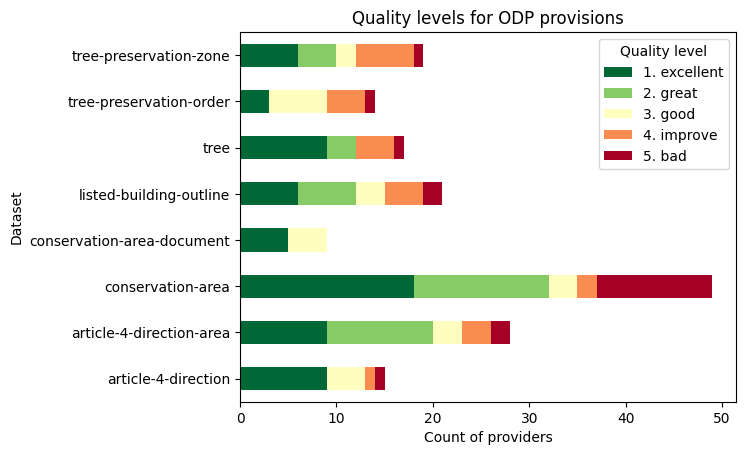

In [97]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap('RdYlGn_r')
colors = [cmap(i / 4) for i in range(5)]

level_map = {
    1: "1. excellent",
    2: "2. great",
    3: "3. good",
    4: "4. improve",
    5: "5. bad"}

qual_chart = qual_summary_odp.groupby(["pipeline", "quality_level"], as_index=False).agg(
    n_providers = ("quality_level", "count")
)

qual_chart["quality_level_label"] = qual_chart["quality_level"].map(level_map)
qual_chart.sort_values(["pipeline", "quality_level_label"], inplace=True)
qual_chart.pivot(columns = "quality_level_label", values = "n_providers", index = "pipeline").plot.barh(stacked = True, color = colors)

# Add labels and title
plt.xlabel('Count of providers')
plt.ylabel('Dataset')
plt.title('Quality levels for ODP provisions')
plt.legend(title='Quality level')

plt.show

<Axes: ylabel='pipeline'>

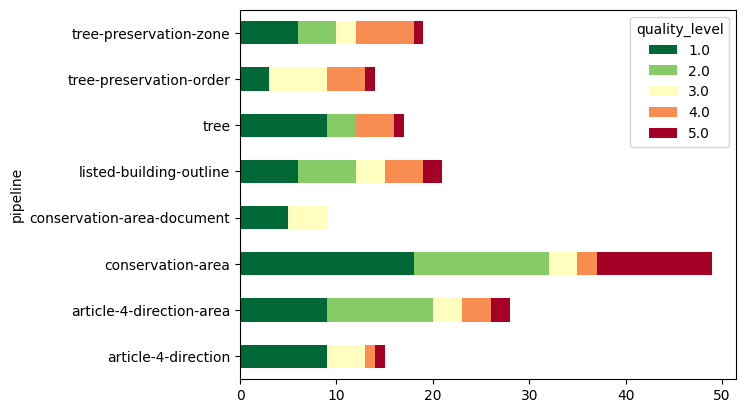

In [75]:
qual_summary_odp.groupby(["pipeline", "quality_level"], as_index=False).agg(
    n_providers = ("quality_level", "count")
).pivot(columns = "quality_level", values = "n_providers", index = "pipeline").plot.barh(stacked = True, colormap = "RdYlGn_r")